# Sudoku AR solver

By: Matan Mizrachi 207299363, Moshiko Maymon 315995548

In [14]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from funcs import *

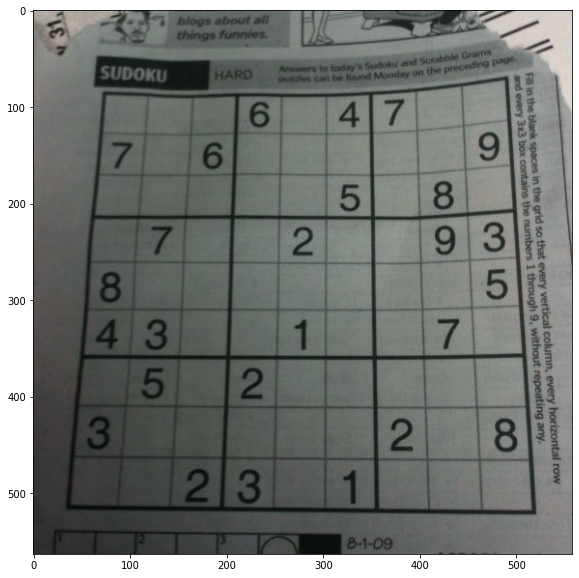

In [15]:
sudoku = cv2.imread('sudoku.jpg')
plt.figure(figsize=(10,10))
plt.imshow(sudoku)

## 1. Image pre-processing

My pre-processing includes:
- Gray
- Gaussian
- Denoising
- Threshold (adaptive)
- Bitwise
- Dilate


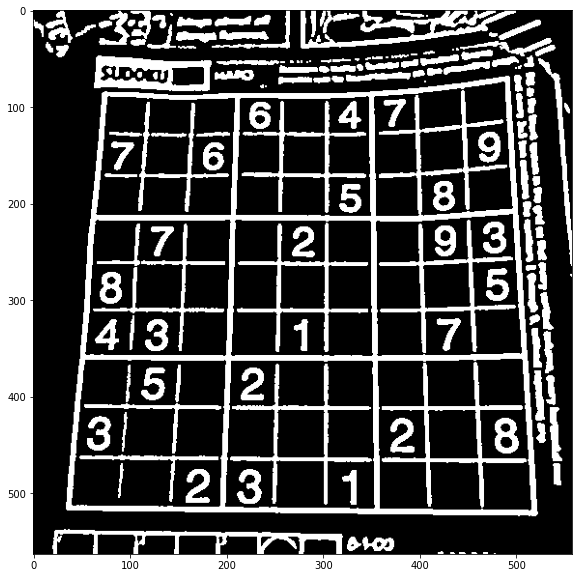

In [16]:
image = imagePreProcessing(sudoku)
plt.figure(figsize=(10,10))
plt.imshow(image, cmap='gray')

## 2. Extract Sudoku area

We need to find the Sudoku area to know where to looking for the Sudoku cells and numbers.


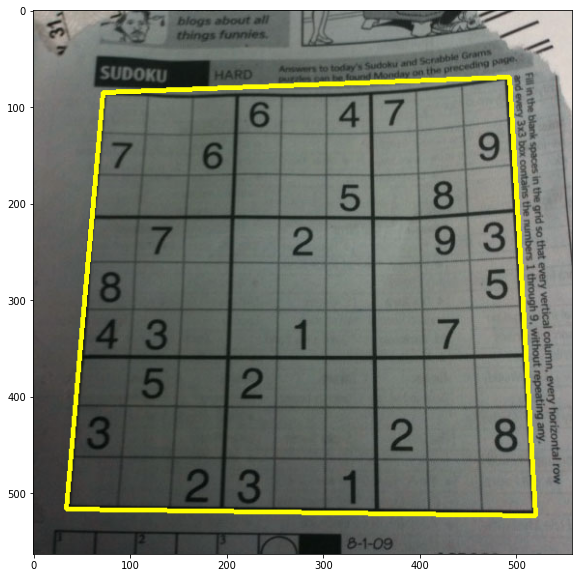

In [17]:
approx = findArea(image)


draw_approx = sudoku.copy()
cv2.drawContours(draw_approx, [approx], -1, (255, 255, 0), 3)
plt.figure(figsize=(10, 10))
plt.imshow(draw_approx)
plt.show()


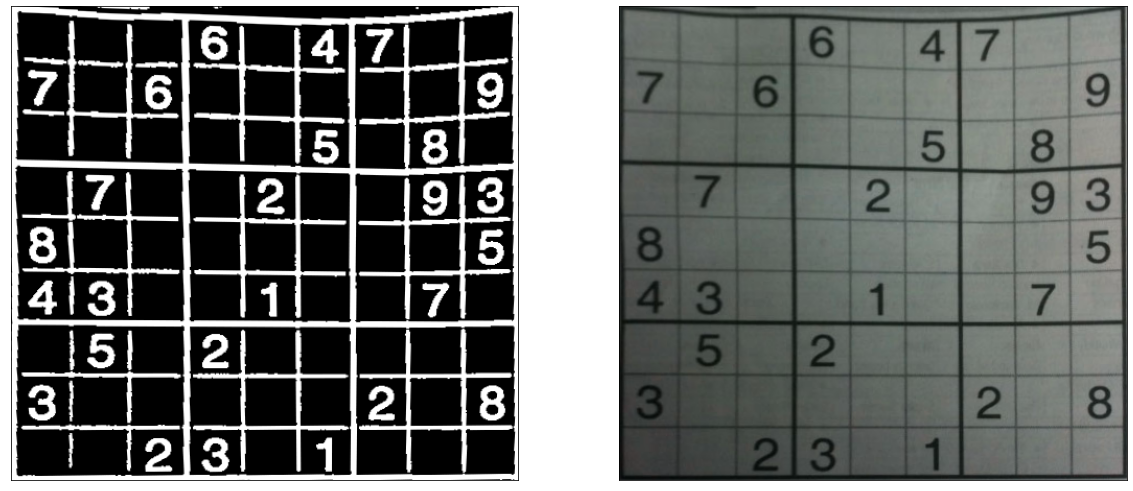

In [18]:
wraped, M = four_point_transform(image, approx)
wraped_original, M_original = four_point_transform(sudoku, approx)

plt.figure(figsize=(20, 20))

plt.subplot(1,2,1)
plt.imshow(wraped, cmap='gray')
plt.xticks([]), plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(wraped_original)
plt.xticks([]), plt.yticks([])

plt.show()

## 3. Recognize numbers in cells

### 3.1. Split image to sudoku cells


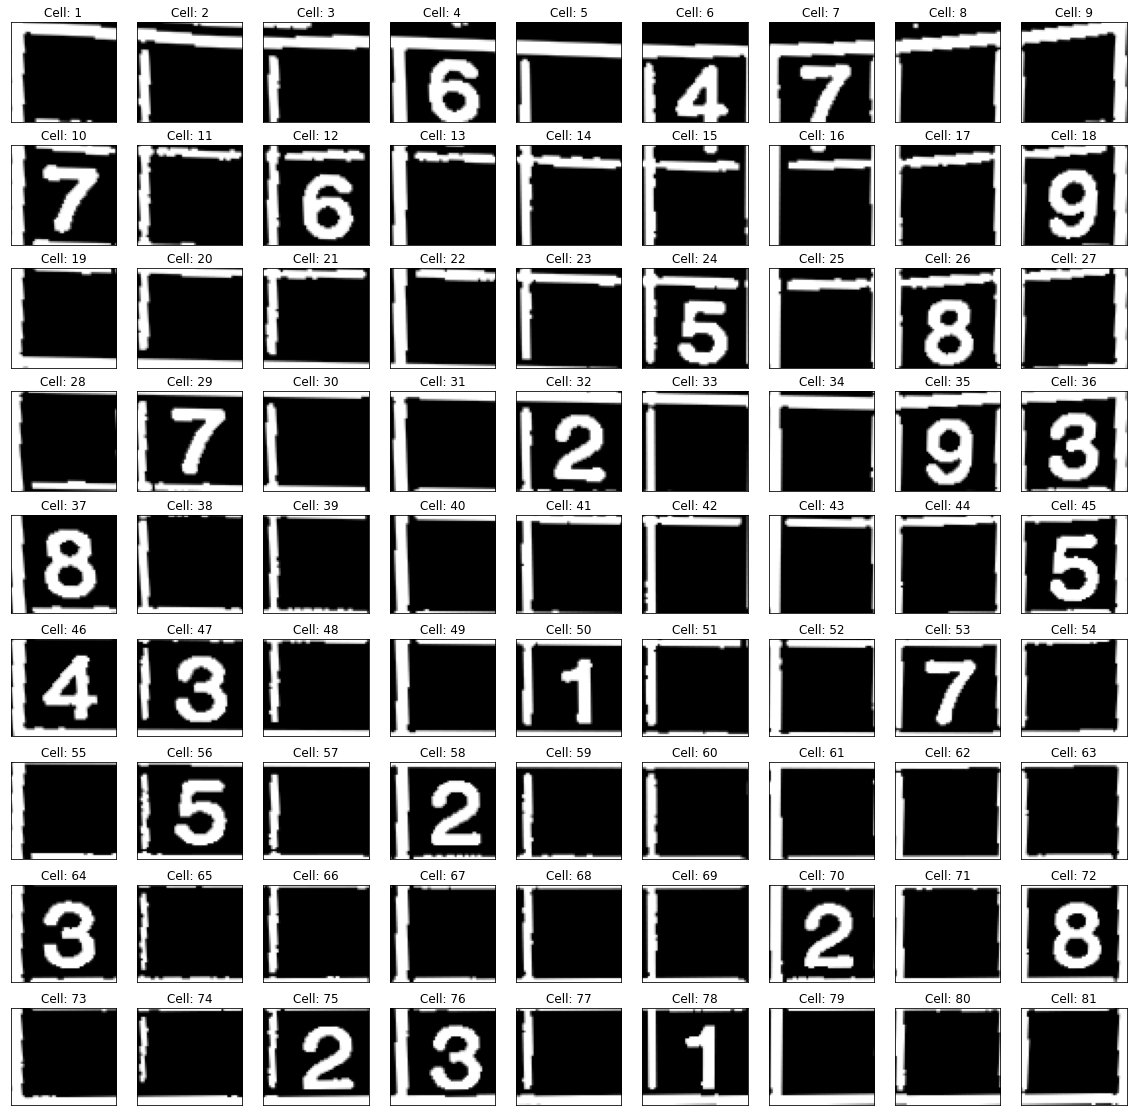

In [19]:
cells = imageToSudokuCells(wraped)
cells_original = imageToSudokuCells(wraped_original)

plt.figure(figsize=(20,20))
for i in range(81):
    plt.subplot(9,9,i+1)
    plt.imshow(cells[i][0],cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.title('Cell: ' + str(i+1))

plt.show()

### 3.2 SVM model for number detection

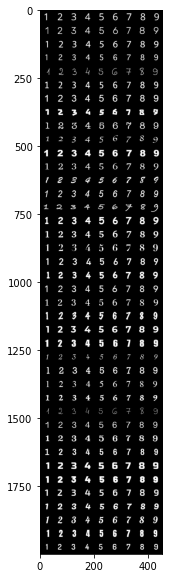

In [20]:
digits = cv2.imread('digitst.jpg',0)
plt.figure(figsize=(10,10))
plt.imshow(digits,cmap='gray')
plt.show()

In [21]:
cells50x50 = [np.hsplit(row,9) for row in np.vsplit(digits,40)]
digits_dataset = np.array(cells50x50)
digits_dataset = digits_dataset.reshape(-1, 2500)

n = np.arange(1, 10)
labels = np.tile(n, int(len(digits_dataset) / 9))

Split dataset to test and train

In [22]:
split_index = int(len(digits_dataset) * 0.75)

train = digits_dataset[:split_index].reshape(-1,2500)
test = digits_dataset[split_index:].reshape(-1,2500)


train_labels = labels[:split_index]
test_labels =  labels[split_index:]

print('Train:', len(train))
print('Test:', len(test))

Train: 270
Test: 90


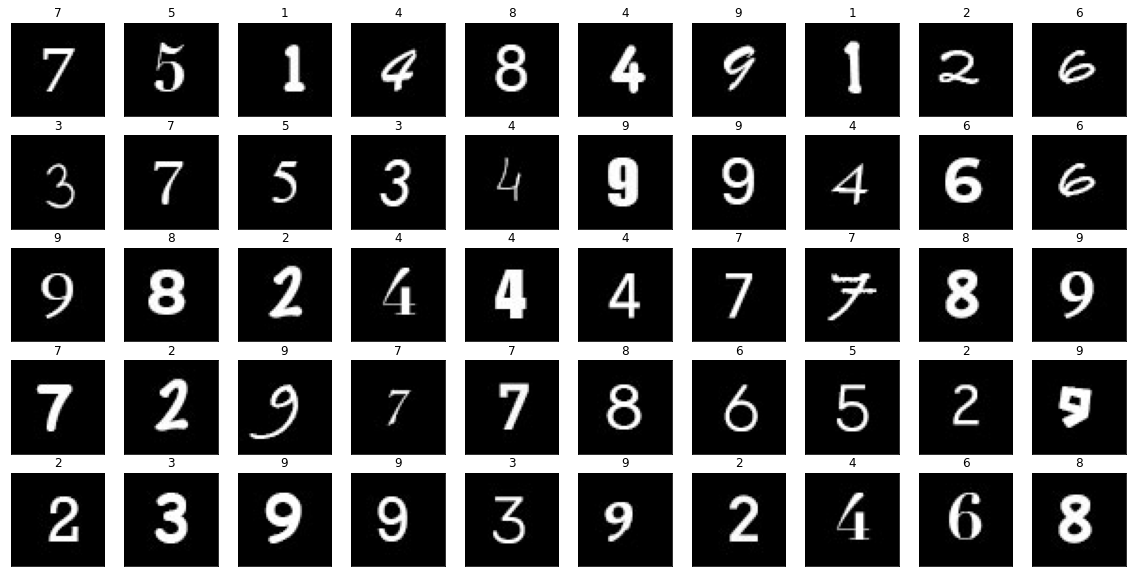

In [23]:
# display some (random) data:
plt.figure(figsize=(20,10))
for i in range(50):
    plt.subplot(5,10,i+1)
    j = np.random.randint(0,len(train))
    plt.imshow(train[j].reshape(50,50),cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.title(train_labels[j])

#### 3.2.2 Train 
Training my SVM model on train data (create hog of each image before)

In [24]:
winSize = (40,40)
blockSize = (20,20)
blockStride = (10,10)
cellSize = (5,5)
nbins = 9
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)
train_hog = []
test_hog = []

for i,im in enumerate(train):
    train_hog.append(hog.compute(im.reshape(50,50)))
        
for i,im in enumerate(test):
    test_hog.append(hog.compute(im.reshape(50,50)))

train_hog = np.asarray(train_hog)
test_hog = np.asarray(test_hog)    

svm = runSVM(train_hog, train_labels)

result = svm.predict(test_hog)

print('SVM Accuracy score:',accuracy_score(test_labels, result[1]))

SVM Accuracy score: 0.9888888888888889


In [25]:
print(confusion_matrix(test_labels, result[1]))

[[10  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0]
 [ 0  0  9  0  0  0  0  1  0]
 [ 0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0 10]]


#### 3.2.3. Predict 
Predict image digit with SVM model

Extract digit from the cell into a new image in a new size of 50x50 (dataset item size).  
Clean the cell from the noise and find the number in it.

Show area of digits in the original cells

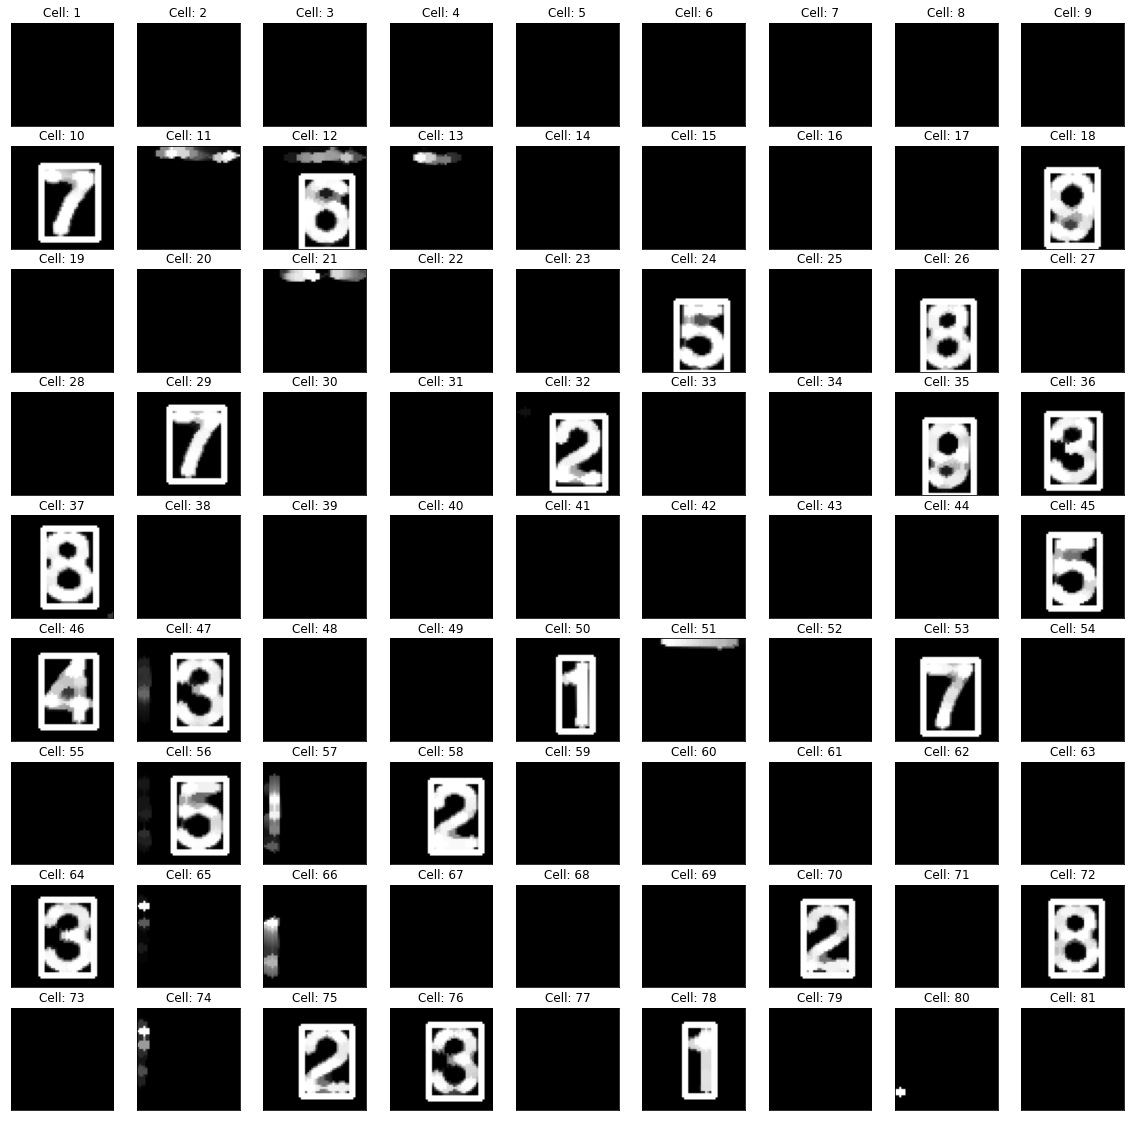

In [26]:
plt.figure(figsize=(20,20))

digits = []

for i in range(len(cells)):
    digit, image = extract_digit(cells[i][0], (5, 5))
    digits.append(digit)
  
    # Show area of digit
    plt.subplot(9,9,i+1)
    plt.imshow(image, cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.title('Cell: ' + str(i+1))
    
plt.show()

Predict each cell image digit and create a vector of all The Sudoku numbers.  
Show the SVM result of each image.

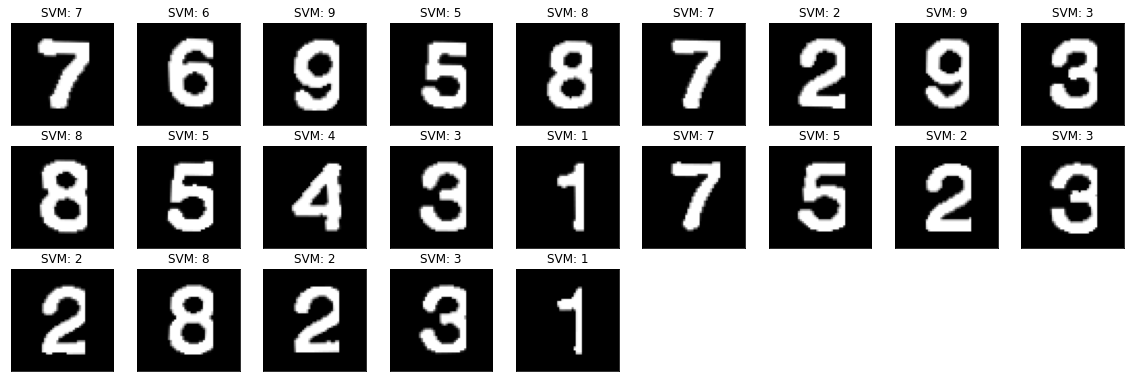

In [27]:
sudoku_numbers = np.zeros(81)

plt.figure(figsize=(20,20))
j = 0
for i in range(len(digits)):
    if digits[i] is not None:
        svm_res = predict(digits[i], hog, svm)
        sudoku_numbers[i] = int(svm_res[1][0])
    
        plt.subplot(9,9,j+1)
        plt.imshow(digits[i], cmap='gray')
        plt.xticks([]), plt.yticks([])
        plt.title('SVM: ' + str(int(svm_res[1][0])))
        j+=1
plt.show()

## 4. Solve Sudoku
Solve sudoku with Backtracking algorithm  
Based on https://www.geeksforgeeks.org/sudoku-backtracking-7/

In [28]:
# Draw sudoku
sudoku_numbers = sudoku_numbers.reshape(9,9).astype(np.int8)

print('Sudoku SVM Result')
print(sudoku_numbers)


Sudoku SVM Result
[[0 0 0 0 0 0 0 0 0]
 [7 0 6 0 0 0 0 0 9]
 [0 0 0 0 0 5 0 8 0]
 [0 7 0 0 2 0 0 9 3]
 [8 0 0 0 0 0 0 0 5]
 [4 3 0 0 1 0 0 7 0]
 [0 5 0 2 0 0 0 0 0]
 [3 0 0 0 0 0 2 0 8]
 [0 0 2 3 0 1 0 0 0]]


Find Sudoku solutions, else return zeros matrix.

In [29]:
solved = find_sudoku_solution(sudoku_numbers)

if solved is not None:
    print('The Sudoku solution:')
    print(solved)
else:
    solved = np.zeros(81)
    print('No solution\n')

No solution



## 5. Draw solution back

Draw each digit on original cells.  
Set digit height and position by cell size.

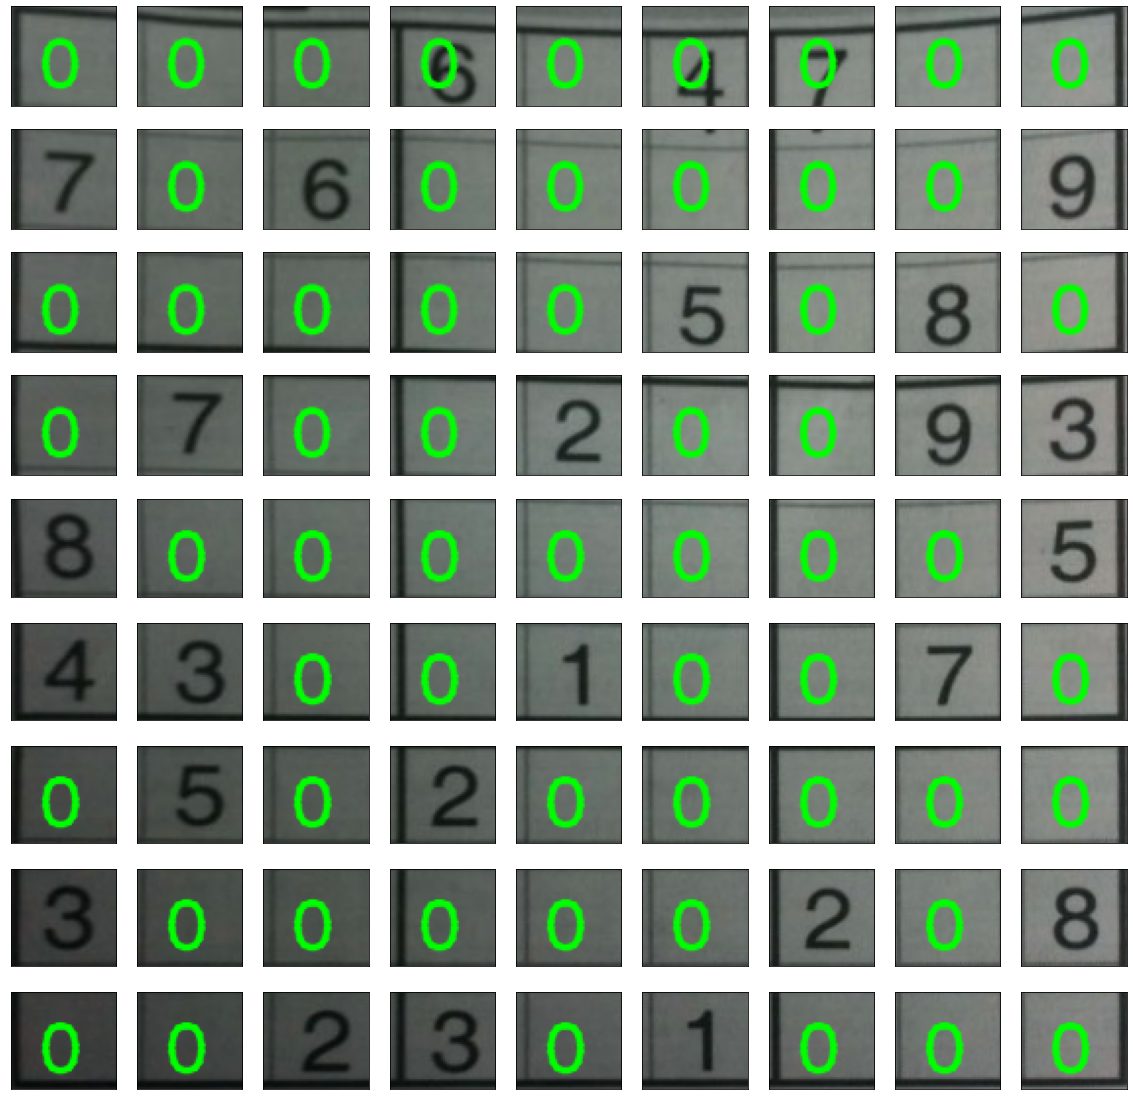

In [30]:
cells_draw = drawOnSodukoCells(cells_original, solved.flatten(), sudoku_numbers.flatten())

plt.figure(figsize=(20,20))

for i in range(len(cells_draw)):
    img = cells_draw[i]

    plt.subplot(9,9,i+1)
    plt.imshow(img)
    plt.xticks([]), plt.yticks([])

plt.show()

Join all the Sudoku cells into one Sudoku image

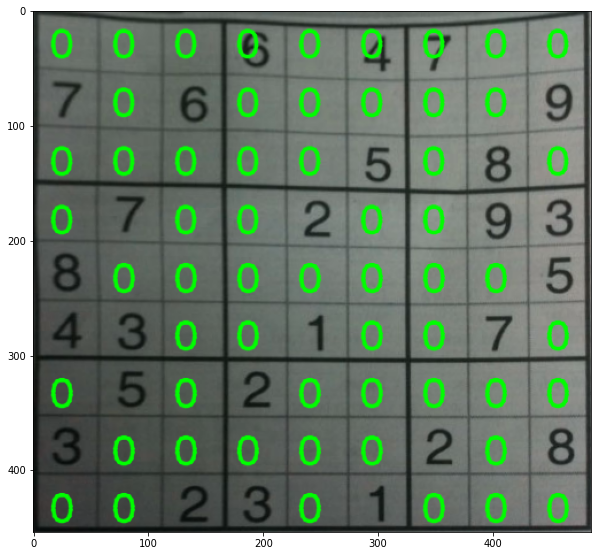

In [31]:
wraped_with_digit = sudokuCellsToImage(cells_draw, wraped_original)

plt.figure(figsize=(10, 10))
plt.imshow(wraped_with_digit)
plt.show()

Draw back sudoku image on original Sudoku image (using reverse prespective)

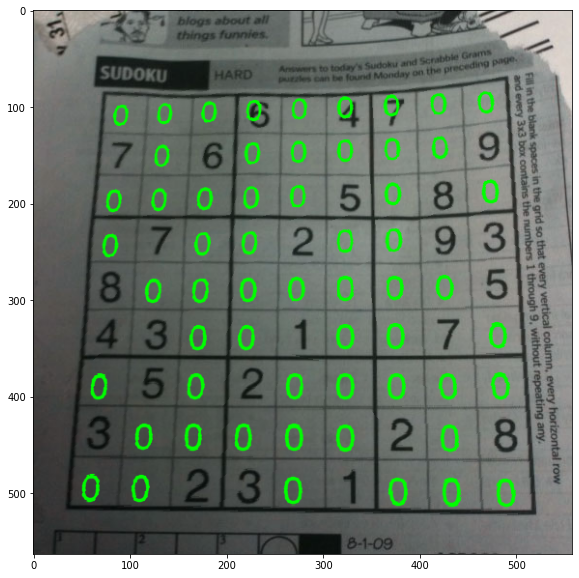

In [32]:
restored = reversePerspective(wraped_with_digit, M_original, sudoku)

plt.figure(figsize=(10, 10))

plt.imshow(restored, cmap='gray')
plt.show()

## Create Video

Run all the algroithm on sudoku video

cap = cv2.VideoCapture(0) 
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') # note the lower case
out = cv2.VideoWriter('output.mp4',fourcc, cap.get(cv2.CAP_PROP_FPS), (int(cap.get(3)), int(cap.get(4))))

prev_sudoku_sol = np.zeros((9, 9))
prev_svm = np.zeros((9, 9))

while cap.isOpened():
    ret, frame = cap.read() 
    if not ret:
        break
    
    try:
        # pre processing
        frame_pre = imagePreProcessing(frame)

        # find sudoku area
        _, approx = findArea(frame_pre)

        # if find sudoku area
        if len(approx) == 4:

            # extract sudoku area
            wraped, M = four_point_transform(frame_pre, approx)
            wraped_original, M_original = four_point_transform(frame, approx)
        
            # get sudoku cells
            cells = imageToSudokuCells(wraped)
            cells_original = imageToSudokuCells(wraped_original)
        
            # extract all digits
            digits = []

            for i in range(len(cells)):
                digit, image = extract_digit(cells[i][0], (5, 8))
                digits.append(digit)
                
            # only if find digits
            if len(digits) > 5:
                # predict sudoku numbers
                sudoku_numbers = np.zeros(81)

                for i in range(len(digits)):
                    if digits[i] is not None:
                        svm_res = predict(digits[i], hog, svm)
                        sudoku_numbers[i] = int(svm_res[1][0])

                sudoku_numbers = sudoku_numbers.reshape(9,9).astype(np.int8)
    
                # check if sudoku page change
                if len(sudoku_numbers[sudoku_numbers != prev_svm]) > 9:
                    prev_sudoku_sol = np.zeros((9, 9))
                    prev_sudoku_sol_i = 0
                
                # solve only if has change in the svm numbers
                if not np.array_equal(sudoku_numbers, prev_svm):
                    prev_svm = sudoku_numbers
                    
                    # solve sudoku 
                    solved = find_sudoku_solution(sudoku_numbers)

                    if solved is None:
                        solved = prev_sudoku_sol
                    
                    prev_sudoku_sol = solved
                
                else:
                    sloved = prev_sudoku_sol
                    

                # draw solution on the cells
                color = (128,0,0)
                cells_draw = drawOnSodukoCells(cells_original, solved.flatten(), sudoku_numbers.flatten(), color)

                # combine cells to one image
                wraped_with_digit = sudokuCellsToImage(cells_draw, wraped_original)

                # draw sudoku solution back
                restored = reversePerspective(wraped_with_digit, M_original, frame)

                cv2.imshow('Sudoku book',restored)
                out.write(restored)

            else:
                cv2.imshow('Sudoku book', frame)
                out.write(frame)
                
        else:
            cv2.imshow('Sudoku book', frame)
            out.write(frame)
                
    except:
        cv2.imshow('Sudoku book', frame)
        out.write(frame)
    
    if cv2.waitKey(3) & 0xFF == ord('q'): break

cap.release()
out.release()
cv2.destroyAllWindows()

